In [16]:
import mlflow
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool

import graph_reinforcement_learning_using_blockchain_data as grl
from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

True

In [17]:
dataset = torch.load(config.FLASHBOTS_Q2_DATA_DIR / "state_graphs.pt", weights_only=False)
max_feats_len = 0

for vals in dataset.values():
    for graphs in vals:
        if graphs.x.shape[1] > max_feats_len:
            max_feats_len = graphs.x.shape[1]

for vals in dataset.values():
    for graphs in vals:
        graphs.x = grl.pad_features(graphs.x, max_feats_len)

data_list = [d for sublist in dataset.values() for d in sublist]

data_loader = DataLoader(
    data_list, batch_size=256, shuffle=False, exclude_keys=["account_mapping"], drop_last=False
)

In [18]:
model_uri = "mlflow-artifacts:/330930495026013213/1f3f3d97f6a14569b9f2f285c5a98bb4/artifacts/model"
model = mlflow.pytorch.load_model(model_uri)

In [19]:
model.eval()
unsup_list, y_list = [], []
device = torch.device("mps")
with torch.no_grad():
    for data in tqdm(data_loader):  # or any loader you like
        data = data.to(device)

        # 1️⃣ unsupervised graph vector  (encoder → mean-pool)
        z_nodes = model.encoder(data)  # (N_nodes, 256)
        unsup_emb = global_mean_pool(z_nodes, data.batch)  # (batch, 256)

        unsup_list.append(unsup_emb.cpu())
        y_list.append(data.y.cpu())

unsup_X = torch.cat(unsup_list).numpy()  # e.g. shape (N_graphs, 256)
y = torch.cat(y_list).numpy()

100%|██████████| 583/583 [00:20<00:00, 28.44it/s]


In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(unsup_X)

pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(X_scaled)

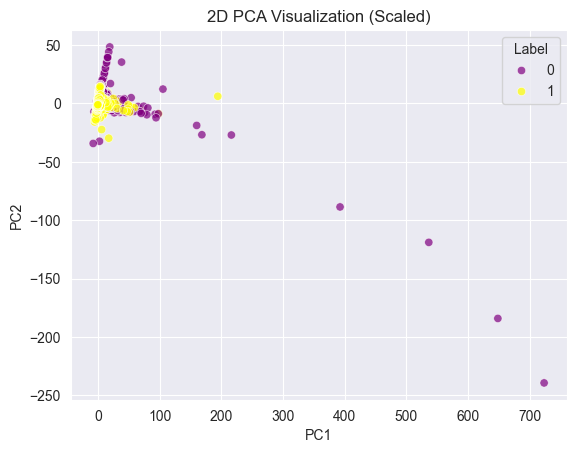

In [29]:
df_plot = pd.DataFrame({"PC1": components[:, 0], "PC2": components[:, 1], "Label": y})

sns.scatterplot(
    data=df_plot, x="PC1", y="PC2", hue="Label", palette=["purple", "yellow"], alpha=0.7
)
plt.title("2D PCA Visualization (Scaled)")
plt.show()